# 2. Multiclass Support Vector Machine (SVM) and Softmax classifier

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD** (Stochastic Gradient Descent)
- **visualize** the final learned weights
- do all of the above for the Softmax classifer

First let us setup some code for this notebook:

In [1]:
%matplotlib inline

import random
from random import randrange
import os
import time
import math
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt

# set some plot defaults:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Get the Data

Ignore this step if you have already downloaded the data from exercise 1.

In [2]:
#!wget -P /home/min-joon/cifar-10 -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar xvzf /home/min-joon/cifar-10/cifar-10-python.tar.gz  -C /home/min-joon/cifar-10
#!rm /home/min-joon/cifar-10/cifar-10-python.tar.gz

In [3]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

We can now use the above methods to lead the data and as a sanity check, we print out the size of the training and test data:

In [4]:
cifar10_dir = '/home/min-joon/cifar-10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Explore the data

Again we show a few examples of training images from each label class:

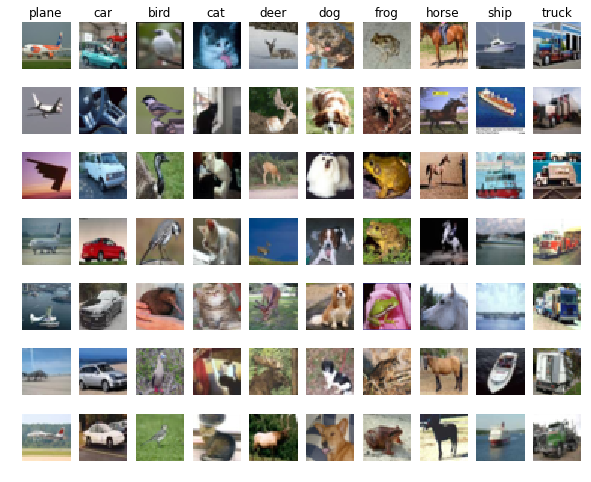

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Sub-Sampling

In order to speed up the execution of code in this exercise we will take a small sample of the original data:

In [6]:
num_training = 49000
num_validation = 1000
num_test = 1000

Our validation set will be `num_validation` points from the original training set:

In [7]:
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

Similarly, our training set will be the first `num_training` points from the original training set:

In [8]:
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

Finally, we use the first `num_test` points of the original test set as our test set and print out the shapes of these sets:

In [9]:
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Preprocessing the data

In order to do the pixel comparison we reshape our RGB images into long vectors of pixels (actually rows of the matrix):

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


We then subtract the mean image from train and test data by computing the mean image based on the training data:

[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


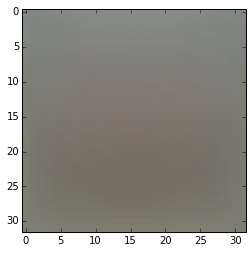

In [11]:
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))

In [12]:
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Finally we append the the bias dimension of ones (i.e. bias trick) so that our SVM only has to worry about optimizing a single weight matrix W. Also, lets transform both data matrices so that each image is a column:

In [13]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print X_train.shape, X_val.shape, X_test.shape

(3073, 49000) (3073, 1000) (3073, 1000)


# SVM classifier

Here we define the initial SVM loss function which is a very naive implementation of the loss given by

$$
L = \frac{1}{N} \sum_i \sum_{j\neq y_i} \left[ \max(0, f(\vec{x}_i, W)_j - f(\vec{x}_i, W)_{y_i} + 1) \right] + \lambda R(W)
$$

where $R(W) = \sum_k\sum_l w_{k,l}^2$:

In [14]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops)
    Inputs:
    - W: K x D array of weights
    - X: D x N array of data images. Each data is a D-dimensional column
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    - reg: (float) regularization strength (lambda)
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
   
    # compute the loss and the gradient
    delta = 1
    num_classes = W.shape[0]
    num_train = X.shape[1]
    loss = 0.0
    for i in xrange(num_train):
        margin_count = 0 
        scores = W.dot(X[:, i])
        correct_class_score = scores[y[i]]
        for j in xrange(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + delta  #note delta = 1
            if margin > 0:
                margin_count += 1
                loss += margin
                dW[j] += X[:,i]
        dW[y[i]] -= margin_count * X[:,i]
                #dW[j, :] += (X[:, i]).T
    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dW   /= num_train

    # Add regularization to the loss.
    loss += 0.5 * reg * np.sum(W * W)
    dW   += reg * W

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################

    return loss, dW

In [15]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(10, 3073) * 0.0001 
loss, grad = svm_loss_naive(W, X_train, y_train, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.245460


The `grad` returned from the function above is right now always zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical grads
  in these dimensions.
  """
  h = 1e-5

  x.shape
  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print 'numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error)

Now we can numerically compute the gradient along several randomly chosen dimensions, and compare them with your analytically computed gradient. The numbers should match almost exactly along all dimensions:

In [17]:
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -11.042981 analytic: -11.043152, relative error: 7.773090e-06
numerical: 7.484564 analytic: 7.485181, relative error: 4.120080e-05
numerical: 24.543252 analytic: 24.546553, relative error: 6.724698e-05
numerical: 36.701148 analytic: 36.702268, relative error: 1.525373e-05
numerical: 4.732062 analytic: 4.731085, relative error: 1.032167e-04
numerical: -1.321608 analytic: -1.321182, relative error: 1.610369e-04
numerical: 9.288638 analytic: 9.291416, relative error: 1.495018e-04
numerical: -25.251435 analytic: -25.250563, relative error: 1.726107e-05
numerical: 0.748104 analytic: 0.747707, relative error: 2.654403e-04
numerical: 1.941340 analytic: 1.938395, relative error: 7.591969e-04


## Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

## Vectorised Version of SVM

Next implement the function `svm_loss_vectorized`, for now only compute the loss, and then the gradient later:

In [52]:
import scipy.linalg.fblas

def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero
  delta = 1.0
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  scores = W.dot(X)
  D, num_train = X.shape
  correct_class_scores = scores[y, range(num_train)]
  margins = np.maximum(0, scores - correct_class_scores + delta)
  margins[y, range(num_train)] = 0

  loss += np.sum(margins)/num_train
  loss += 0.5 * reg * np.sum(W * W)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  num_pos = np.sum(margins > 0 , axis = 0)
  dscores = np.zeros(scores.shape)
  dscores[margins > 0] = 1
  dscores[y,range(num_train)] = -num_pos
  #xT = dscores.dot(X.T) # This is very slow
  xT = scipy.linalg.fblas.dgemm(alpha=1.0, a=dscores.T, b=X.T, trans_a=True) # Faster but still slow
  dW = xT / num_train + reg * W

  #dim dW = K * D, X = D * N , X^T = N * D, dscores = K * N 
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [48]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

Naive loss: 9.245460e+00 computed in 6.576016s


In [53]:
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

Vectorized loss: 9.245460e+00 computed in 7.851597s


In [41]:
# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

difference: -0.000000


## Vectorised Gradient

Next complete the implementation of `svm_loss_vectorized` above, and compute the gradient of the loss function in a vectorized way.  The naive implementation and the vectorized implementation should match, but the vectorized version should still be much faster:

In [55]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

Naive loss and gradient: computed in 6.656963s


In [56]:
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

Vectorized loss and gradient: computed in 7.834476s


The loss is a single number, so it is easy to compare the values computed by the two implementations. The gradient on the other hand is a matrix, so we use the Frobenius norm to compare them:

In [57]:
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

difference: 0.000000


## Linear SVM Classifier

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient we can define our linear SVM classifier class:

In [65]:
class LinearClassifier:

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: D x N array of training data. Each training point is a D-dimensional
         column.
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    dim, num_train = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = np.random.randn(num_classes, dim) * 0.001

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      indices = np.random.choice(num_train, batch_size, replace = True)
      X_batch = X[: , indices]
      y_batch = y[indices]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W = self.W - learning_rate*grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print 'iteration %d / %d: loss %f' % (it, num_iters, loss)

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    y_pred = np.argmax(self.W.dot(X), axis = 0)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: D x N array of data; each column is a data point.
    - y_batch: 1-dimensional array of length N with labels 0...K-1, for K classes.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass

class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

## Stochastic Gradient Descent

You now need to implement the SGD to minimize the loss in the method `train` above:

In [66]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 784.190235
iteration 100 / 1500: loss 284.624890
iteration 200 / 1500: loss 106.479118
iteration 300 / 1500: loss 42.057981
iteration 400 / 1500: loss 18.826791
iteration 500 / 1500: loss 10.997570
iteration 600 / 1500: loss 6.972009
iteration 700 / 1500: loss 6.190050
iteration 800 / 1500: loss 5.681895
iteration 900 / 1500: loss 5.327003
iteration 1000 / 1500: loss 5.523971
iteration 1100 / 1500: loss 5.750150
iteration 1200 / 1500: loss 4.932866
iteration 1300 / 1500: loss 5.021895
iteration 1400 / 1500: loss 5.743943
That took 54.394357s


A useful debugging strategy is to plot the loss as a function of iteration number:

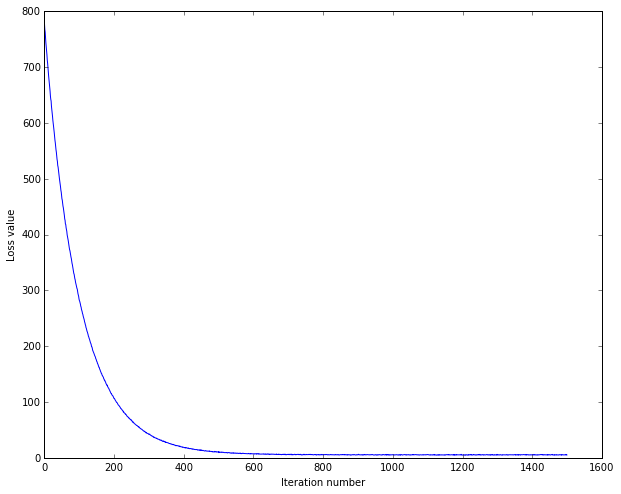

In [67]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

Now write the `predict` function and  and evaluate the performance on both the training and validation set:

In [68]:
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.369469
validation accuracy: 0.371000


## Hyperparameter Tuning

Use the validation set to tune hyperparameters (regularization strength and the SGD learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of about 0.4 on the validation set:

In [157]:
learning_rates = [0.5e-7, 1e-7]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
lmin = learning_rates[0]
lmax = learning_rates[1]
rmin = regularization_strengths[0]
rmax = regularization_strengths[1]
for i in np.linspace(lmin, lmax, num=3):
    for j in np.linspace(rmin, rmax, num=5):
         svm = LinearSVM()
         svm.train(X_train, y_train, learning_rate=i, reg=j,
                      num_iters=600, verbose=False)
         y_train_pred = svm.predict(X_train)
         y_val_pred = svm.predict(X_val)
         val = np.mean(y_val == y_val_pred)
         results[(i,j)] = (np.mean(y_train == y_train_pred),val)
         best_val = max(best_val, val)
         if best_val == val :
                best_svm = svm      
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.326633 val accuracy: 0.344000
lr 5.000000e-08 reg 6.250000e+04 train accuracy: 0.345224 val accuracy: 0.351000
lr 5.000000e-08 reg 7.500000e+04 train accuracy: 0.351612 val accuracy: 0.357000
lr 5.000000e-08 reg 8.750000e+04 train accuracy: 0.352592 val accuracy: 0.355000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.356469 val accuracy: 0.367000
lr 7.500000e-08 reg 5.000000e+04 train accuracy: 0.357980 val accuracy: 0.373000
lr 7.500000e-08 reg 6.250000e+04 train accuracy: 0.357673 val accuracy: 0.367000
lr 7.500000e-08 reg 7.500000e+04 train accuracy: 0.365714 val accuracy: 0.383000
lr 7.500000e-08 reg 8.750000e+04 train accuracy: 0.357000 val accuracy: 0.357000
lr 7.500000e-08 reg 1.000000e+05 train accuracy: 0.353816 val accuracy: 0.360000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.364122 val accuracy: 0.376000
lr 1.000000e-07 reg 6.250000e+04 train accuracy: 0.357816 val accuracy: 0.375000
lr 1.000000e-07 reg 7.500000

## Visualization of Results

Let us visualize the cross-validation results by plotting the training accuracy:

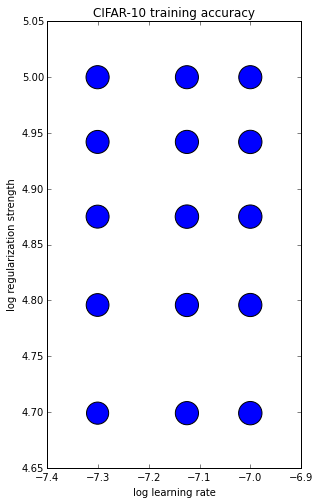

In [158]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

We can also plot the validation accuracy:

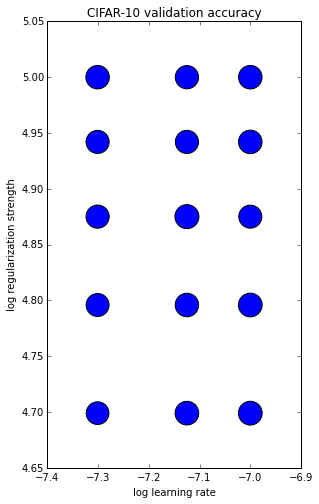

In [159]:
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

Next we evaluate the best SVM on the test set:

In [160]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.368000


Finally, we visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at:

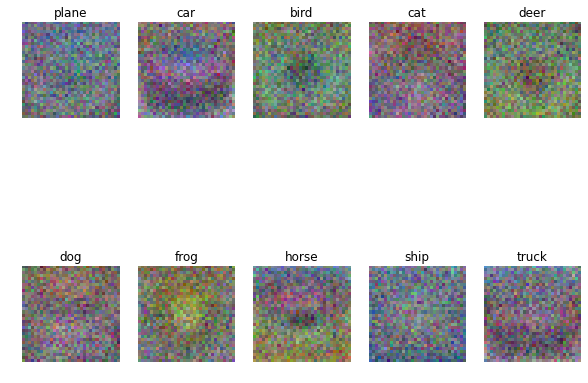

In [161]:
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** 
The visualized weights look like blurry versions of their labels with their predominat color intensified.
As the accuracy gets higher trough better hyperparameters the weight looks more pixelated and grainy then before.

<hr>

## Softmax Classifier

Now let us implement the Softmax classifier class based on the Softmax loss function. Bellow we have two implementations of the loss function and then the class. Recall like the SVM the function mapping $f(\vec{x}_i,W) = W \vec{x}_i$ remains the same, but we now interpret these scores as the  unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss that has the form:

$$ L_i = - \log(\frac{\exp(f_{y_i})}{\sum_j \exp(f_j)})$$

or equivalently:

$$ L_i = - f_{y_i} + \log \sum_j \exp(f_j),$$

where again we use the notation $f_j$ to mean the $j$-th  element of the vector of class scores $f$. As before the full loss for the dataset is the mean of $L_i$ over all the images together with a regularization term of $R(W)$ defined above.

In [ ]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs:
  - W: C x D array of weights
  - X: D x N array of data. Data are D-dimensional columns
  - y: 1-dimensional array of length N with labels 0...K-1 for K classes
  - reg: (float) regularization strength
  Returns:
  a tuple of:
  - loss as single float
  - gradient with respect to weights W, an array of same size as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  D, num_train = X.shape
  num_class = W.shape[0]
  scores = W.dot(X)
  scores = np.exp(np.dot(W, X))
    
  for i in xrange(num_train):
    for j in xrange(num_class):
        loss += -(u)
  
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [125]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  D, num_train = X.shape
  scores = W.dot(X) #bias trick

  scores -= np.max(scores, axis = 0)
  p = np.exp(scores)
  p /= np.sum(p, axis=0)

  loss_cost = -np.sum(np.log(p[y,range(y.size)]))/num_train
  loss_reg = 0.5 * reg * np.sum(W*W)
  loss = loss_cost + loss_reg

  dscores = p # dL_i/df_j = p_yi
  dscores [y,range(y.size)] -= 1.0
  dW = dscores.dot(X.T)/num_train + reg * W
    

  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [146]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

### Naive softmax loss

First implement the naive softmax loss function with nested loops. We then generate a random softmax weight matrix and use it to compute the loss:

In [ ]:
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

### Inline Question 3:
Why do we expect our loss to be close to $-\log(0.1)$? Explain briefly.

**Your answer:** *Fill this in*


### Naive softmax gradient

Next complete the implementation of `softmax_loss_naive` and implement a (naive) version of the gradient that uses nested loops:

In [ ]:
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

### Vectorized softmax loss

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster:

In [162]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

NameError: name 'softmax_loss_naive' is not defined

### Hyperparameters

Next, use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [ ]:
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

We can now evaluate on the test set to get the best softmax result:

In [ ]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

### Visualize

Finally we visualize the learned weights for each class:

In [ ]:
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])